In [3]:
!pip install pandas
!pip install scikeras[tensorflow]
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 74.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 58.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing inst

In [4]:
!chmod +x /kaggle/input/classification/download.sh
!source /kaggle/input/classification/download.sh

chmod: changing permissions of '/kaggle/input/classification/download.sh': Read-only file system
--2024-04-17 15:13:13--  https://uapt33090-my.sharepoint.com/:u:/g/personal/jmourao_ua_pt/EXXMICXdVaBLpsdqzqWVpXQBXzEYQnoVWnRuClkbfXk0Jg?e=fEcsdp&download=1
Resolving uapt33090-my.sharepoint.com (uapt33090-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to uapt33090-my.sharepoint.com (uapt33090-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/jmourao_ua_pt/Documents/CAA1_data/processed_data.zip?ga=1 [following]
--2024-04-17 15:13:13--  https://uapt33090-my.sharepoint.com/personal/jmourao_ua_pt/Documents/CAA1_data/processed_data.zip?ga=1
Reusing existing connection to uapt33090-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 173887511 (166M) [application/x-zip-compressed]
Saving to: 'data.zip'

data.zip            100%[===================>] 165.83M  47.4

In [5]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as  plt
import gc
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [6]:
def alter_data(X):
    X = X.values
    turn = X[:,64]
    black_to_play = np.where(turn == -1)[0]
    # Multiply the values from indexes 0 to 63 by -1 where index 64 is 0
    X[black_to_play, :64] *= -1
    X = X[:, 0:64].reshape((X.shape[0], 8 , 8))
    return X

In [7]:
def load_n_datasets(n,foldername):
    all_datasets = []
    filenames = os.listdir(foldername)
    for i in range(n):
        filename = filenames[i]
        if filename.endswith('.csv'):
            dataset = pd.read_csv(os.path.join(foldername, filename))
            all_datasets.append(dataset)
    combined_dataset = pd.concat(all_datasets, ignore_index=True)
    
    X =  combined_dataset.iloc[:,0:-1]
    y =  combined_dataset["Evaluation"].astype(float)
    combined_dataset = None
    dataset = None
    all_datasets = None
    return X,y

In [8]:
def bit_map(X):
    channels = np.zeros((X.shape[0],8, 8, 12))  # 12 channels for 6 types of pieces for each player
    # Generate separate channels for each player
    for player in range(2):  # 0 for white pieces, 1 for black pieces
        if player ==0:
            for piece_type in range(6):  # 6 types of pieces
                piece_mask = X == (piece_type + 1)
                channels[:, :, :, player * 6 + piece_type] = piece_mask.astype(np.float32)
        else:
            for piece_type in range(6):  # 6 types of pieces
                piece_mask = -1*(X == (-piece_type - 1))
                channels[:, :, :, player * 6 + piece_type] = piece_mask.astype(np.float32)
    X = None
    return channels

In [9]:
n_datasets = 2
X_chess_data,y_chess_data = load_n_datasets(n_datasets,'processed_data')
X_chess_data,_,y_chess_data,_ = train_test_split(X_chess_data, y_chess_data, test_size=0.2, random_state=42)

X = pd.DataFrame(X_chess_data)
y = pd.DataFrame((y_chess_data))
X = alter_data(X)
X = bit_map(X)
print(type(X_chess_data))
print(X_chess_data.shape)



<class 'pandas.core.frame.DataFrame'>
(1594833, 69)


In [10]:
y = (y - y.min()) / (y.max()-y.min())

In [11]:
X_chess_data = None
y_chess_data = None
gc.collect()

26

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#80% training, 10% validation and 10% testing.

input_shape = X_train.shape[1:]

In [13]:
X = None
y = None
gc.collect()

0

In [14]:
import tensorflow
from keras.models import Sequential 
from keras.layers import Conv2D, Flatten, BatchNormalization, Dense, Dropout
from keras.activations import elu
from keras.optimizers import SGD,Adam

tensorflow.random.set_seed(101)

In [15]:
def create_model_mlp():
    
    n_neurons = 1024
    n_neurons2 = 1024
    n_neurons3 = 50
    dropout = 0.6
    learning_rate = 0.001
    
    mlp_model = Sequential()

    # Add hidden layers with ReLU activation and dropout
    mlp_model.add(Dense(n_neurons, activation='relu', input_shape=input_shape))
    mlp_model.add(Dropout(dropout))
    mlp_model.add(Dense(n_neurons2, activation='relu'))
    mlp_model.add(Dropout(dropout))
    mlp_model.add(Dense(n_neurons3, activation='relu'))
    mlp_model.add(Dropout(dropout))

    # Layer to ensure the output matches the labels in shape
    mlp_model.add(Flatten())
    
    # Add output layer with linear activation for regression
    mlp_model.add(Dense(1, activation='sigmoid'))

    # Compile model with Adam optimizer
    adam = Adam(learning_rate=learning_rate, beta_1=0.90, beta_2=0.99, epsilon=1e-8)
    mlp_model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])

    # Print model summary
    mlp_model.summary()
    return mlp_model

In [16]:
def create_model_cnn():
    cnn_model = Sequential()
    n_neurons = 500
    dropout = 0.4
    activation = 'elu'
    
    # Add convolutional layers with ELU activation and batch normalization
    cnn_model.add(Conv2D(20, (5, 5), activation=elu, input_shape=input_shape, padding='same'))

    
    cnn_model.add(Conv2D(50, (3, 3), activation=elu, padding='same'))
 
    # Add fully connected layer
    cnn_model.add(Flatten())

    cnn_model.add(Dense(n_neurons, activation=activation))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(dropout))
    cnn_model.add(Dense(n_neurons, activation=activation))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(dropout))
    
    # Add output layer with linear activation for regression
    cnn_model.add(Dense(1, activation='sigmoid'))

    # Compile model with SGD optimizer
  
    cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

    # Print model summary
    cnn_model.summary()
    return cnn_model

In [17]:
n_splits = 5
history = []
models = []

# Define the size of each fold
fold_size = len(X_train) // n_splits
model = create_model_cnn()
for i in range(n_splits):
      
    start = i * fold_size
    end = (i + 1) * fold_size if i < n_splits - 1 else len(X_train)
    gc.collect()
    # Split data into train and test folds
    X_train_fold = np.concatenate([X_train[:start], X_train[end:]], axis=0)
    y_train_fold = np.concatenate([y_train[:start], y_train[end:]], axis=0)
    X_test_fold = X_train[start:end]
    y_test_fold = y_train[start:end]
    gc.collect() 

    # Create and train model
    
    models.append(model)
    history.append(model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=128, verbose=1,validation_data=(X_test_fold, y_test_fold)))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 20)       │         6,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 50)       │         9,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,600,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,870,571 (7.14 MB)

 Trainable params: 1,868,571 (7.13 MB)

 Non-trainable params: 2,000 (7.81 KB)

Epoch 1/5


I0000 00:00:1713366886.575707     106 service.cc:145] XLA service 0x5b4502ed5960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713366886.575750     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  46/8971 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.1520 - mae: 0.3423

I0000 00:00:1713366892.188402     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8971/8971 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.0053 - mae: 0.0293 - val_loss: 0.0013 - val_mae: 0.0147
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0013 - val_mae: 0.0135
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0013 - mae: 0.0157 - val_loss: 0.0014 - val_mae: 0.0140
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0015 - val_mae: 0.0142
Epoch 5/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0020 - val_mae: 0.0163
Epoch 1/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0014 - val_mae: 0.0138
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0013 - mae: 0.0156 - val_loss: 0.0017 - val_mae: 0.0144
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0012 - mae: 0.0155 - val_loss: 0.0014 - val_mae: 0.0141
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/s

In [18]:
n_splits = 5
history1 = []
models1 = []

# Define the size of each fold
fold_size = len(X_train) // n_splits

for i in range(n_splits):
      
    start = i * fold_size
    end = (i + 1) * fold_size if i < n_splits - 1 else len(X_train)
    gc.collect()
    # Split data into train and test folds
    X_train_fold = np.concatenate([X_train[:start], X_train[end:]], axis=0)
    y_train_fold = np.concatenate([y_train[:start], y_train[end:]], axis=0)
    X_test_fold = X_train[start:end]
    y_test_fold = y_train[start:end]
    gc.collect() 

    # Create and train model
    model = create_model_mlp()
    models1.append(model)
    history1.append(model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=128, verbose=1,validation_data=(X_test_fold, y_test_fold)))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 8, 8, 1024)     │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8, 8, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8, 8, 50)       │        51,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │         3,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,363 (4.26 MB)

 Trainable params: 1,117,363 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 122s 13ms/step - loss: 0.0015 - mae: 0.0168 - val_loss: 0.0013 - val_mae: 0.0137
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0137
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0137
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 5/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0137


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 8, 8, 1024)     │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8, 8, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8, 8, 50)       │        51,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         3,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,363 (4.26 MB)

 Trainable params: 1,117,363 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 120s 13ms/step - loss: 0.0015 - mae: 0.0168 - val_loss: 0.0013 - val_mae: 0.0137
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 5/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0138


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 8, 8, 1024)     │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8, 8, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8, 8, 50)       │        51,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │         3,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,363 (4.26 MB)

 Trainable params: 1,117,363 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 120s 13ms/step - loss: 0.0015 - mae: 0.0167 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0014 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0136
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 111s 12ms/step - loss: 0.0014 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0137
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 110s 12ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0139
Epoch 5/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0139


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 8, 8, 1024)     │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8, 8, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 8, 8, 50)       │        51,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │         3,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,363 (4.26 MB)

 Trainable params: 1,117,363 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 122s 13ms/step - loss: 0.0015 - mae: 0.0168 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 110s 12ms/step - loss: 0.0014 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0138
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0139
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 108s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0140
Epoch 5/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0145 - val_loss: 0.0013 - val_mae: 0.0139


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 8, 8, 1024)     │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8, 8, 1024)     │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 8, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 8, 8, 50)       │        51,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │         3,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,117,363 (4.26 MB)

 Trainable params: 1,117,363 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 122s 13ms/step - loss: 0.0014 - mae: 0.0167 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 2/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 110s 12ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0134
Epoch 3/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 113s 13ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0135
Epoch 4/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0135
Epoch 5/5
8971/8971 ━━━━━━━━━━━━━━━━━━━━ 109s 12ms/step - loss: 0.0013 - mae: 0.0144 - val_loss: 0.0013 - val_mae: 0.0135


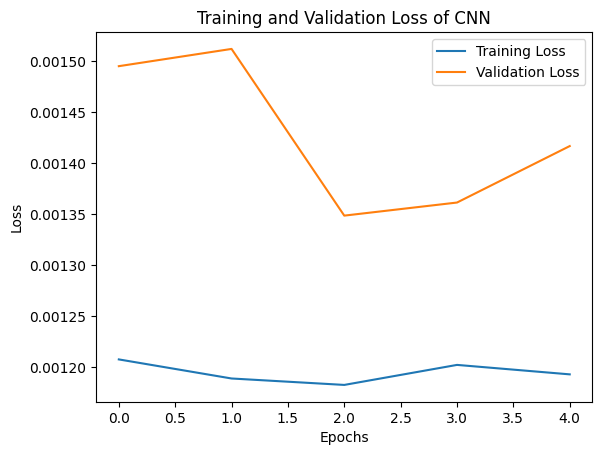

In [19]:
import matplotlib.pyplot as plt

lowest_val_mae_index = min(range(len(history)), key=lambda i: min(history[i].history['val_mae']))

# Get the corresponding model and history
best_model = models[lowest_val_mae_index]
best_history = history[lowest_val_mae_index]

# Plot training and validation MAE
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_CNN_reg.png")
plt.show()


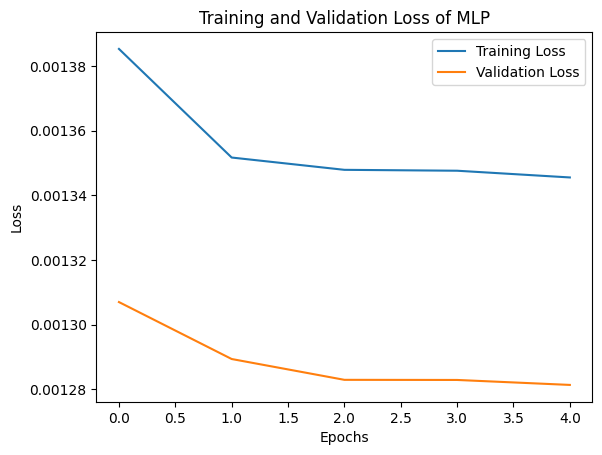

In [20]:
import matplotlib.pyplot as plt

lowest_val_mae_index = min(range(len(history1)), key=lambda i: min(history1[i].history['val_mae']))

# Get the corresponding model and history
best_model1 = models1[lowest_val_mae_index]
best_history1 = history1[lowest_val_mae_index]

# Plot training and validation MAE
plt.plot(best_history1.history['loss'], label='Training Loss')
plt.plot(best_history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss of MLP')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_MLP_reg.png")
plt.show()


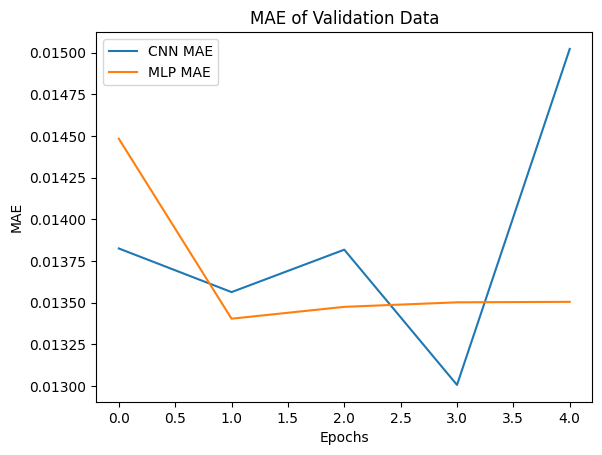

In [21]:

# Plot training and validation MAE
plt.plot(best_history.history['val_mae'], label='CNN MAE')
plt.plot(best_history1.history['val_mae'], label='MLP MAE')
plt.title('MAE of Validation Data')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.savefig("mae_MLP_reg.png")
plt.show()


In [22]:
import pandas as pd

# Assuming you have best_model, best_history, best_model1, best_history1, and test_data
# where test_data is your test dataset

# Define a function to extract MAE values from history object
def extract_mae(history):
    return history.history['mae'][-1], history.history['val_mae'][-1]

# Calculate MAE for best_model
best_model_train_mae, best_model_val_mae = extract_mae(best_history)
best_model_test_mae = best_model.evaluate(X_test, y_test, verbose=0)[1]

# Calculate MAE for best_model1
best_model1_train_mae, best_model1_val_mae = extract_mae(best_history1)
best_model1_test_mae = best_model1.evaluate(X_test, y_test, verbose=0)[1]

# Create DataFrame
data = {
    'Model': ['CNN', 'MLP'],
    'Train MAE': [best_model_train_mae, best_model1_train_mae],
    'Validation MAE': [best_model_val_mae, best_model1_val_mae],
    'Test MAE': [best_model_test_mae, best_model1_test_mae]
}

df = pd.DataFrame(data)

# Print the DataFrame
print(df)


  Model  Train MAE  Validation MAE  Test MAE
0   CNN   0.015730        0.015022  0.015165
1   MLP   0.014465        0.013505  0.013659


In [23]:
latex_table = df.to_latex(index=False)
# Write LaTeX table to a file
with open('model_evaluation_table.tex', 'w') as f:
    f.write(latex_table)
